In [1]:
import axisrules as axis
import numpy as np
import pandas as pd
import itertools
from tqdm import tqdm
import math

In [81]:



axis_rules = [axis.VoterDeletion, axis.MinimalFlips, axis.BallotCompletion, 
              axis.MinimalSwaps, axis.ForbiddenTriples]

ranking_rules =[compute_best_VD, compute_best_FT_triplets]

n_trys = 100
n_voters = 100
n_candidates = 7

approval_radius = 0.1
noise = 0.2

model = axis.RankingDistanceModel(noise, approval_radius)
kendallTau = np.zeros((len(axis_rules)+len(ranking_rules), n_trys))
for j in tqdm(range(n_trys)):
    rankings, approval = model(n_candidates,n_voters)
    real = model.axis
    i = 0
    for rule in axis_rules:
        res = rule(approval).bruteforce()
        kt_res = 0
        for x in res:
            kt_res += min(axis.kandallTau(real[::-1], x[0]), axis.kandallTau(real, x[0]))

        kendallTau[i][j] = kt_res/len(res)
        i += 1

    for rule in ranking_rules:
        res = rule(rankings, np.ones(len(rankings)))
        kt_res = 0
        for x in res:
            kt_res += min(axis.kandallTau(real[::-1], x[0]), axis.kandallTau(real, x[0]))

        kendallTau[i][j] = kt_res/len(res)
        i += 1

# save csv 
df = pd.DataFrame(kendallTau.T)
df.columns = ["VD", "MF", "BC", "MS", "FT", "VD_rank", "FT_rank"]
df.to_csv("data/noisyDistanceMean.csv", index=False)


100%|██████████| 100/100 [00:38<00:00,  2.59it/s]


In [82]:
kendallTau.mean(axis=1)

array([3.54512374, 3.51728205, 2.71125   , 2.6475    , 2.6815    ,
       7.82016667, 1.73666667])

In [86]:
approval_radius = 0.4
noise = 0.1

model = axis.RankingDistanceModel(noise, approval_radius)
rankings, approval = model(n_candidates,n_voters)

# distribution of number of approvals
n_app = approval.sum(axis=1)
# count unique
np.unique(n_app, return_counts=True)

(array([1., 2., 3., 4., 5., 6.]), array([ 1, 17, 29, 23, 23,  7], dtype=int64))

In [62]:
kendallTau.mean(axis=1)

array([2.50033333, 2.11333333, 2.83616667, 2.153     , 1.84833333,
       7.74608333, 2.88      ])

In [5]:



axis_rules = [axis.VoterDeletion, axis.MinimalFlips, axis.BallotCompletion, 
              axis.MinimalSwaps, axis.ForbiddenTriples]

ranking_rules =[compute_best_VD, compute_best_FT_triplets]

n_trys = 1000
n_voters = 100
n_candidates = 7

approval_radius = 0.4
noise = 0.2

list_radius = [0.6]
list_noise = [0.1,0.2,0.3,0.4,0.5]

for approval_radius in list_radius:
    for noise in list_noise:
        print(approval_radius, noise)
        model = axis.RankingDistanceModel(noise, approval_radius)
        kendallTau = np.zeros((len(axis_rules)+len(ranking_rules), n_trys))
        for j in tqdm(range(n_trys)):
            rankings, approval = model(n_candidates,n_voters)
            real = model.axis
            i = 0
            for rule in axis_rules:
                res = rule(approval).bruteforce()
                kt_res = 0
                for x in res:
                    kt_res += min(axis.kandallTau(real[::-1], x[0]), axis.kandallTau(real, x[0]))

                kendallTau[i][j] = kt_res/len(res)
                i += 1

            for rule in ranking_rules:
                res = rule(rankings, np.ones(len(rankings)))
                kt_res = 0
                for x in res:
                    kt_res += min(axis.kandallTau(real[::-1], x[0]), axis.kandallTau(real, x[0]))

                kendallTau[i][j] = kt_res/len(res)
                i += 1
        # save csv 
        df = pd.DataFrame(kendallTau.T)
        df.columns = ["VD", "MF", "BC", "MS", "FT", "VD_rank", "FT_rank"]
        df.to_csv("data/noisyDistanceMean_{}_{}.csv".format(approval_radius, noise), index=False)


0.6 0.1


100%|██████████| 1000/1000 [02:06<00:00,  7.91it/s]


0.6 0.2


100%|██████████| 1000/1000 [05:10<00:00,  3.22it/s]


0.6 0.3


100%|██████████| 1000/1000 [10:38<00:00,  1.57it/s]


0.6 0.4


100%|██████████| 1000/1000 [17:29<00:00,  1.05s/it]


0.6 0.5


100%|██████████| 1000/1000 [22:55<00:00,  1.38s/it]


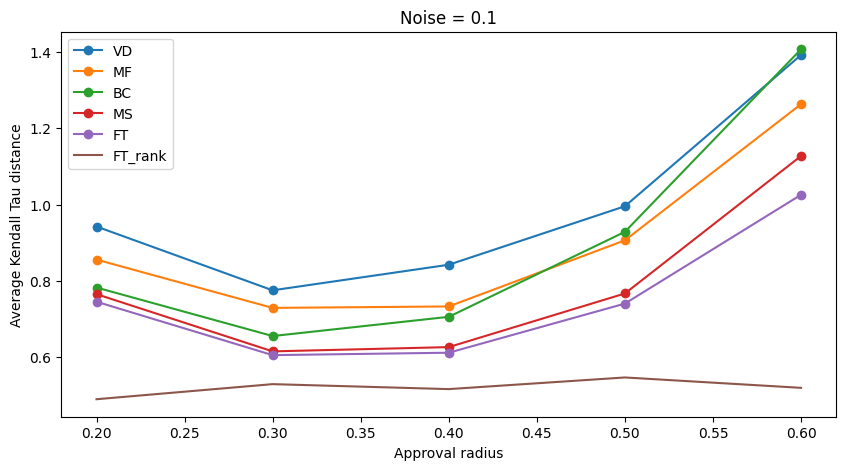

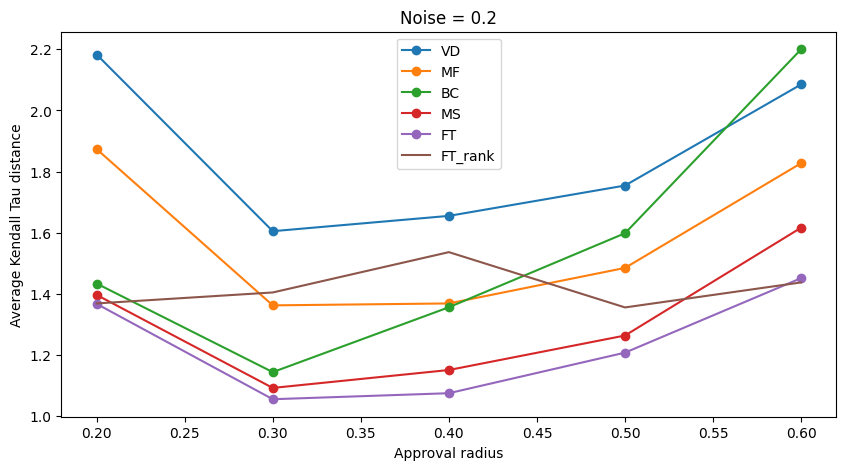

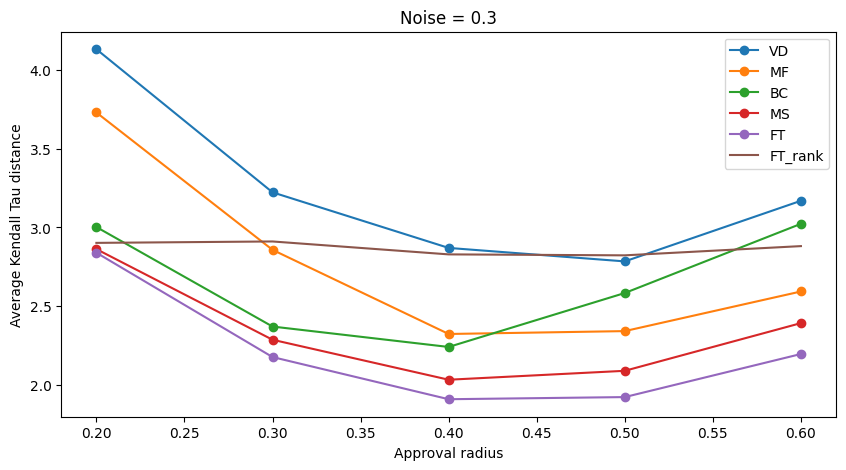

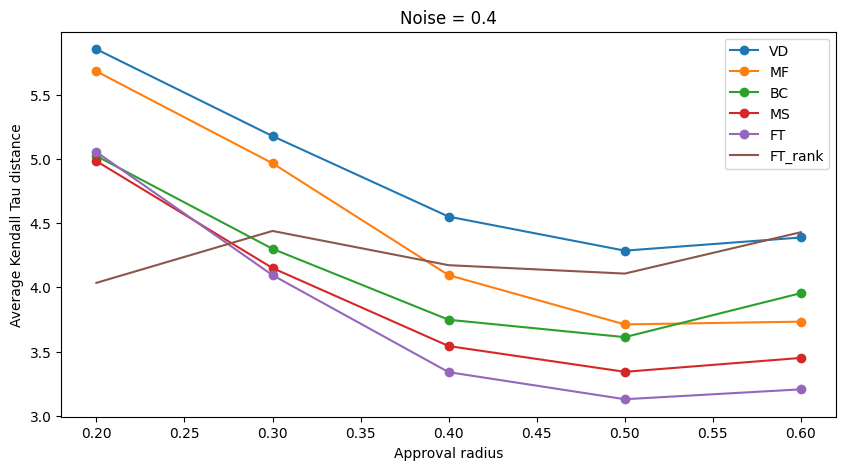

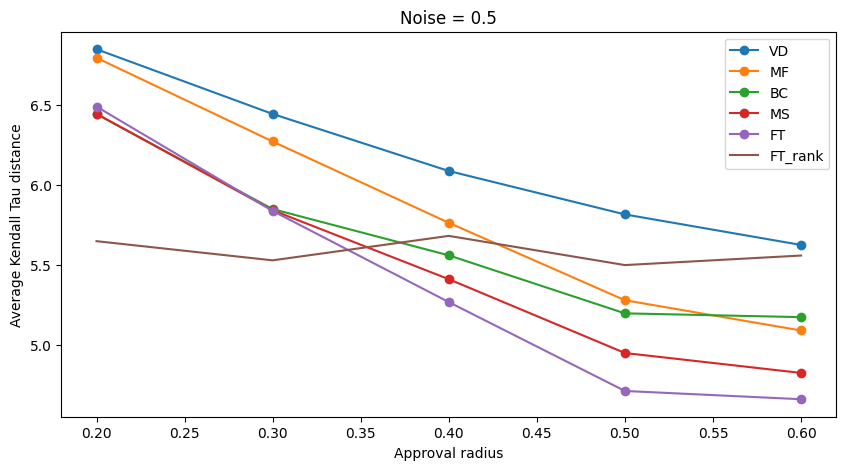

In [5]:
# plot the figures for each sigma (evolution of the mean of the distance)

import matplotlib.pyplot as plt
import tikzplotlib

axis_rules = [axis.VoterDeletion, axis.MinimalFlips, axis.BallotCompletion, 
              axis.MinimalSwaps, axis.ForbiddenTriples]

ranking_rules =["e","e"]

list_radius = [0.2,0.3,0.4,0.5,0.6]
list_noise = [0.1,0.2,0.3,0.4,0.5]
def tikzplotlib_fix_ncols(obj):
    """
    workaround for matplotlib 3.6 renamed legend's _ncol to _ncols, which breaks tikzplotlib
    """
    if hasattr(obj, "_ncols"):
        obj._ncol = obj._ncols
    for child in obj.get_children():
        tikzplotlib_fix_ncols(child)
names = ["VD", "MF", "BC", "MS", "FT", "VD_rank", "FT_rank"]
for noise in list_noise:

    kt_avg_rules = np.zeros((len(axis_rules)+len(ranking_rules), len(list_radius)))
    for i, radius in enumerate(list_radius):
        df = pd.read_csv("data/noisyDistanceMean_{}_{}.csv".format(radius, noise))
        kt_avg_rules[:, i] = df.mean(axis=0)

    fig = plt.figure(figsize=(10,5))
    for i, rule in enumerate(axis_rules):
        plt.plot(list_radius, kt_avg_rules[i], label=names[i], marker='o')
    
    for i, rule in enumerate(ranking_rules):
        if i == 0:
            continue
        plt.plot(list_radius, kt_avg_rules[i+len(axis_rules)], label=names[i+len(axis_rules)])
    
    plt.xlabel("Approval radius")
    plt.ylabel("Average Kendall Tau distance")
    plt.legend()
    plt.title("Noise = {}".format(noise))
    tikzplotlib_fix_ncols(fig) 
    tikzplotlib.save("data/noisyDistanceMean_{}.tex".format(noise))
    plt.show()
    



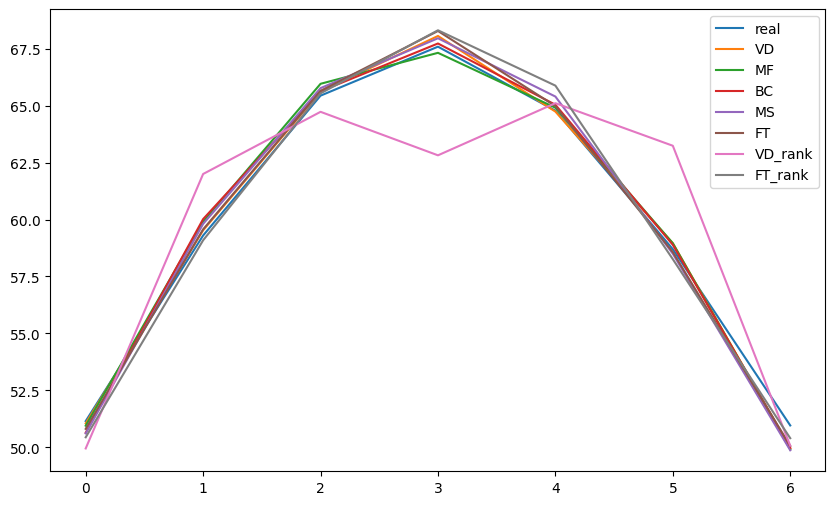

In [96]:
import matplotlib.pyplot as plt

names = ["VD", "MF", "BC", "MS", "FT", "VD_rank", "FT_rank"]
plt.figure(figsize=(10,6))
plt.plot(popularity_axis[-1], label="real")
for i in range(len(axis_rules)+len(ranking_rules)):
    plt.plot(popularity_axis[i], label=names[i])

plt.legend()
plt.show()

In [12]:
path_data = "../../VoteData/Datasets/France 2017/Online/"


votes = []
ids = []
for irv_v in ["irv_1", "irv_2"]:
    df_irv = pd.read_csv(path_data + "votes/%s.csv"%irv_v, index_col=0)

    # keep only row with max value == 11
    df_irv = df_irv[df_irv.max(axis=1) == 11]

    # replace 0 with 12
    df_irv = df_irv.replace(0, 12)

    votes.append(df_irv.values)
    candidates= df_irv.columns.values
    ids.append(df_irv.index.values)

votes = np.concatenate(votes, axis=0)
ids = np.concatenate(ids, axis=0)

voters = pd.read_csv(path_data + "voters.csv", index_col=0)
officials = voters["official_vote"]
off = []
for i in range(len(ids)):
    if ids[i] in officials.index:
        off.append(officials.loc[ids[i]])
    else:
        off.append("None")
officials = off

votes_candidates = [0]*len(candidates)
for cand in officials:
    if cand in candidates:
        votes_candidates[list(candidates).index(cand)] += 1


votes_candidates = 100*np.array(votes_candidates)/np.sum(votes_candidates)
dict_votes_cand = {candidates[i]:votes_candidates[i] for i in range(len(candidates))}

print(votes_candidates)

df_cand = pd.read_csv("../../VoteData/Datasets/France 2017/candidates.csv", index_col=0)

vals = df_cand[["candidate","score"]].values
dict_cand = {v[0]:v[1] for v in vals}

weights_cand = {cand:dict_cand[cand]/dict_votes_cand[cand] for cand in candidates}

weights = []
for i in range(len(officials)):
    if officials[i] in candidates:
        weights.append(weights_cand[officials[i]])
    else:
        weights.append(0)

weights = np.array(weights)
print(votes.shape)
print(weights.shape)

#### now reduce the matrix based on doubles 

dict_votes = {}
dict_weights = {}

for i in range(len(votes)):
    v = votes[i]
    strv = str(v)
    if strv not in dict_votes:
        dict_votes[strv] = v
        dict_weights[strv] = 0
    dict_weights[strv] += weights[i]

list_strv = list(dict_votes.keys())
votes = np.array([dict_votes[strv] for strv in list_strv])
weights = np.array([dict_weights[strv] for strv in list_strv])

print(votes.shape)
print(weights.shape)


[ 0.24091548  1.60610319  0.24091548  1.34511142  4.69785184 18.53041558
  0.76289902  2.08793415 20.77896005 47.86187513  1.84701867]
(5796, 11)
(5796,)
(5126, 11)
(5126,)


In [3]:

def is_single_peaked(axis, vote):
    """
    Check if a vote is single peaked for a given axis
    """
    curr = 13
    decr = True
    for i in range(len(axis)):
        v = vote[axis[i]]
        if decr and v > curr:
            decr = False
        if not decr and v < curr:
            return False
        curr = v

    return True
        


def compute_VD_score(axis, votes, weights, min_score = None):
    """
    Compute the VD score of an axis for a given set of votes and weights
    """
    score = 0
    for vote, weight in zip(votes, weights):
        if not is_single_peaked(axis, vote):
            score += weight
            if min_score is not None and score > min_score:
                return False, None
    return True, score

def compute_best_VD(votes, weights, starting_axis=None):

    n_votes, n_candidates = votes.shape
    cand_l = range(n_candidates-2)

    if starting_axis is not None:
        current_min = compute_VD_score(starting_axis, votes, weights)[1]
        results = [(starting_axis, current_min)]

    else:
        current_min = None
        results = []
    for x in (list(itertools.permutations(cand_l))):
        lx = list(x)
        ok, score = compute_VD_score(lx, votes, weights, current_min)
        if not ok:
            continue
        for i in range(n_candidates-1):
            for j in range(i,n_candidates-1):
                axis = lx[:i]+[n_candidates-2]+lx[i:j]+[n_candidates-1]+lx[j:]
                ok, score = compute_VD_score(axis, votes, weights, current_min)
                if ok:
                    current_min = score
                    results.append((axis, score))
    return [x for x in results if x[1] == current_min]

def print_axis(axis, candidates):
    """
    Print an axis
    """
    print(" < ".join([candidates[i] for i in axis]))

In [129]:
res = compute_best_VD(votes, weights, starting_axis=[4, 1, 2, 8, 5, 9, 10, 0, 6, 3, 7])

100%|██████████| 362880/362880 [23:33<00:00, 256.68it/s]


In [48]:
def compute_FT_score(axis, votes, weights, min_score = None, top=None):
    """
    Compute the VD score of an axis for a given set of votes and weights
    """
    score = 0
    if top == None:
        top = [np.argmin(vote) for vote in votes]
    for i in range(len(votes)):
        vote = votes[i]
        weight = weights[i]
        peak = axis.index(top[i])
        ft = 0
        for i in range(len(axis)):

            if i == peak:
                continue
            elif i < peak:
                v = vote[axis[i]]
                for j in range(i+1, peak):
                    if vote[axis[j]] > v:
                        ft += 1 
            else:
                v = vote[axis[i]]
                for j in range(peak+1, i):
                    if vote[axis[j]] > v:
                        ft += 1

        score += ft * weight
        if min_score is not None and score > min_score:
            return False, None
    return True, score


def compute_best_FT(votes, weights, starting_axis=None):
    
        n_votes, n_candidates = votes.shape
        cand_l = range(n_candidates-2)

        top = [np.argmin(vote) for vote in votes]
    
        if starting_axis is not None:
            current_min = compute_FT_score(starting_axis, votes,  weights, None, top)[1]
            results = [(starting_axis, current_min)]
    
        else:
            current_min = None
            results = []
        for x in (list(itertools.permutations(cand_l))):
            lx = list(x)
            # ok, score = compute_FT_score(lx, votes, weights, current_min)
            # if not ok:
            #     continue
            for i in range(n_candidates-1):
                for j in range(i,n_candidates-1):
                    axis = lx[:i]+[n_candidates-2]+lx[i:j]+[n_candidates-1]+lx[j:]
                    ok, score = compute_FT_score(axis, votes,  weights, current_min, top)
                    if ok:
                        current_min = score
                        results.append((axis, score))
        return [x for x in results if x[1] == current_min]

In [175]:
compute_best_FT(votes, weights, starting_axis=[4, 1, 2, 8, 5, 9, 10, 0, 6, 3, 7])

  0%|          | 0/362880 [00:00<?, ?it/s]


ValueError: 9 is not in list

In [4]:
def votes_to_triplets(votes,weights):
    n_voters, n_candidates = votes.shape

    triplets = np.zeros((n_candidates, n_candidates, n_candidates))

    for i in range(n_voters):
        vote = votes[i]
        weight = weights[i]
        order = np.argsort(vote)
        peak = order[0]
        for i in range(1, len(order)):
            for j in range(i+1, len(order)):
                triplets[peak, order[i], order[j]] += weight
    return triplets

# tt = votes_to_triplets(votes, weights)
# for i in range(len(candidates)):
#     print(candidates[i])
#     print(tt[i])

def compute_FT_score_triplets(axis, triplets, min_score = None):
    score = 0
    for i in range(len(axis)):
        for j in range(i+1, len(axis)):
            for k in range(j+1, len(axis)):
                score += triplets[axis[i], axis[k], axis[j]]
        for j in range(i):
            for k in range(j):
                score += triplets[axis[i], axis[k], axis[j]]
        if min_score is not None and score > min_score:
            return False, None
    return True, score


def compute_best_FT_triplets(votes, weights, starting_axis=None):

    tt = votes_to_triplets(votes, weights)

    n_votes, n_candidates = votes.shape
    cand_l = range(n_candidates-2)

    if starting_axis is not None:
        current_min = compute_FT_score_triplets(starting_axis, tt)[1]
        results = [(starting_axis, current_min)]
    else:
        current_min = None
        results = []

    for x in (list(itertools.permutations(cand_l))):
        lx = list(x)
        # ok, score = compute_FT_score_triplets(lx, tt, current_min)
        # if not ok:
        #     continue
        for i in range(n_candidates-1):
            for j in range(i,n_candidates-1):
                axis = lx[:i]+[n_candidates-2]+lx[i:j]+[n_candidates-1]+lx[j:]
                ok, score = compute_FT_score_triplets(axis, tt, current_min)
                if ok:
                    current_min = score
                    results.append((axis, score))

    return [x for x in results if x[1] == current_min]

In [4]:
res = compute_best_FT_triplets(votes, weights, starting_axis=[0,11,6,10,3,4,9,7,2,8,1,5])

100%|██████████| 3628800/3628800 [17:36:22<00:00, 57.25it/s]        
